In [1]:
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import resize, rescale
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Helper functions for visualization
def display_image(title, image, scale=1.0, cmap='gray'):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(rescale(image, scale, anti_aliasing=False), cmap=cmap)
    plt.axis('off')
    plt.show()


def np_to_00torch(np_array):
    return torch.from_numpy(np_array).float().unsqueeze(0).unsqueeze(0)


def torch_to_np(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())

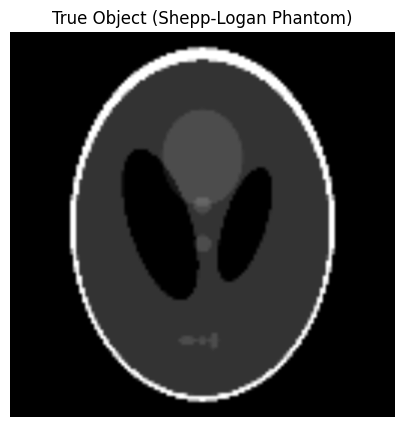

In [3]:
nxd = 128   # Image resolution 128x128
disp_scale = 4
brain_image = shepp_logan_phantom()

# parallel lines at 45 degrees means root(2) is the largest if you wanna consider all pixel
nrd = int(nxd*1.42) # number of radio bins, the largest it can be

nphi = nxd   # number of viewing angles

device = torch.device("cudo:0" if torch.cuda.is_available() else "cpu")

# Resize phantom to desired resolution and convert to tensor
true_object_np = resize(brain_image, (nxd, nxd), anti_aliasing=False)
true_object_torch = np_to_00torch(true_object_np).to(device)

display_image("True Object (Shepp-Logan Phantom)", true_object_np, scale=disp_scale)

In [4]:
# -------------------- Torch system matrix ------------------------
def make_torch_system_matrix(nxd, nrd, nphi):
    system_matrix = torch.zeros(nrd * nphi, nxd * nxd)  # rows = num sinogram bins,, columns = num image pixels
    for xv in range(nxd):
        for yv in range(nxd):   # now have selected pixel(xv, yv)
            for ph in range(nphi):  # now for each angle project that pixel
                yp = -(xv-(nxd*0.5)) * np.sin(ph * np.pi/nphi) + (yv-(nxd*0.5)) * np.cos(ph * np.pi/nphi)
                # -(x * sin() + y * cos()) FBP
                # substract halv the number to define a center/origin as the middle of the image
                # np.pi/nphi to go between 0 and pi

                yp_bin = int(yp + nrd/2.0)
                # nrd = number of radial samples
                system_matrix[yp_bin + ph*nrd, xv + yv*nxd] = 1.0
                # converting a 2D to 1D to build a system matrix, column vector
    return system_matrix

In [5]:
def forward_proj_system_torch(image, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat, torch.reshape(image, (nxd * nxd, 1))), (nphi, nrd))


def back_proj_system_torch(sino, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat.T, torch.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))

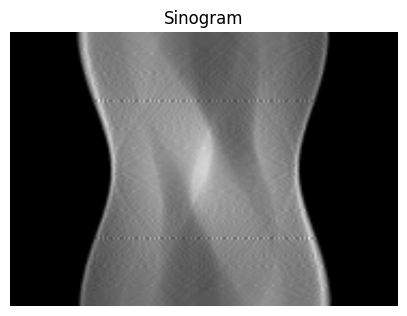

In [6]:
syst_mat = make_torch_system_matrix(nxd, nrd, nphi).to(device)

true_sinogram_torch = forward_proj_system_torch(true_object_torch, syst_mat, nxd, nrd, nphi)
display_image("Sinogram", torch_to_np(true_sinogram_torch), scale=disp_scale)

In [7]:
# MLEM network class
class MLEM_Net(nn.Module):
    # torch.nn is the base class for all pytorch neural network modules
    def __init__(self, sino_for_reonstruction, num_iter):
        super(MLEM_Net, self).__init__()
        # inherit attributes and methods from base class, torch.nn standard requirement!
        self.num_its = num_iter
        # number of iterations
        self.sino_ones = torch.ones_like(sino_for_reonstruction)
         # sinogram just filled with ones
        self.sens_image = back_proj_system_torch(self.sino_ones, syst_mat, nxd, nrd, nphi)
        # sensitivity image = (A^T 1)

    def forward(self, sino_for_reconstruction):
        recon = torch.ones(nxd, nxd).to(device)
        # initial image filled with ones in x and y
        for it in range(self.num_its):
            fpsino = forward_proj_system_torch(recon, syst_mat, nxd, nrd, nphi)
            ratio = sino_for_reconstruction / (fpsino + 1.0e-9)
            correction = back_proj_system_torch(ratio, syst_mat, nxd, nrd, nphi) / (self.sens_image + 1.0e-9)
            # sens image with safety offset
            recon = recon * correction
        return recon

    
# Instantiate and run MLEM network
core_iterations = 10
deepnet = MLEM_Net(true_sinogram_torch, core_iterations).to(device)
mlem_recon = deepnet(true_sinogram_torch)

# CNN Class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=(3, 3)), nn.PReLU(),
            # 1 image in and 8 images out
            nn.Conv2d(8, 8, 7, padding=(3, 3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3, 3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3, 3)), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=(3, 3)), nn.PReLU(),
            # 8 images in and 1 image out
        )

    def forward(self, x):
        x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
        # make sure it's a 4D torch tensor for CNN
        return x


cnn = CNN().to(device)

In [8]:
# MLEM-CNN class
class MLEM_CNN_net(nn.Module):
    def __init__(self, cnn, sino_for_reconstruction, num_iter):
        super(MLEM_CNN_net, self).__init__()
        self.num_iter = num_iter
        self.sino_ones = torch.ones_like(sino_for_reconstruction)
        self.sens_image = back_proj_system_torch(self.sino_ones, syst_mat, nxd, nrd, nphi)
        self.cnn = cnn

    def forward(self, sino_for_reconstruction):
        recon = torch.ones(nxd, nxd).to(device)
        for it in range(self.num_iter):
            fpsino = forward_proj_system_torch(recon, syst_mat, nxd, nrd, nphi)
            ratio = sino_for_reconstruction / (fpsino + 1.0e-9)
            correction = back_proj_system_torch(ratio, syst_mat, nxd, nrd, nphi) / (self.sens_image + 1.0e-9)
            recon = recon * correction
            recon = torch.abs(recon + self.cnn(recon))
            # MLEM is strictly positive so abs() is necessary
        return recon

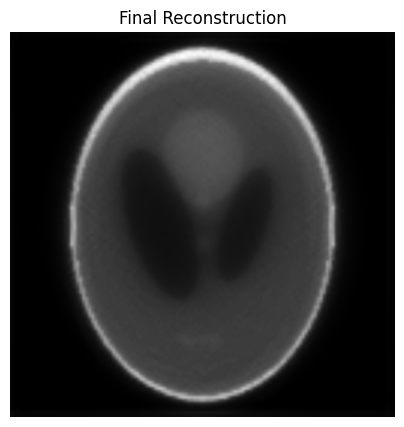

In [9]:
# Instantiate and run MLEM-CNN network
cnn_mlem = MLEM_CNN_net(cnn, true_sinogram_torch, core_iterations).to(device)
mlemcnn_recon = cnn_mlem(true_sinogram_torch)


# Training the network
loss_fun = nn.MSELoss()
# loss function MSE
optimiser = torch.optim.Adam(cnn_mlem.parameters(), lr=0.001)
# updating the parameters with adam

train_loss = []
# keep track of the training value
epochs = 100
for ep in range(epochs):
    rec_out = cnn_mlem(true_sinogram_torch)
    loss = loss_fun(rec_out, torch.squeeze(true_object_torch))
    train_loss.append(loss.item())
    loss.backward()
    # find the gradients
    optimiser.step()
    # does the update
    optimiser.zero_grad()

# Display final reconstruction
display_image("Final Reconstruction", torch_to_np(mlemcnn_recon), scale=disp_scale)